# EECS 595 HW3: Part 4: Exploring BERT

In Parts 1 to 3, you built and pre-trained a tiny BERT-like model for the langauge of product reviews. Pre-training is exciting and necessary, so let's see what the model learned by having it fill in some masks. For this part of the assignment, we'll be working with the pre-trained model you saved at the end of Part 3. You won't be training the model at all; instead, this will be what's called "model inference" where you're only running the forward pass. 

**Important Note:** You can run this notebook to examine your initial pre-trained model from your CPU. However, all of tasks should be done using the fully-trained version you get from Great Lakes.

To start, you'll need to import the relevant code from BERT into this notebook. You can either do this with a copy/paste if your code is finalized, or if you have your code as a script somewhere (e.g., for submitting to Great Lakes for training), you can import the classes and methods with `import` statements from that file, e.g., something like `from myfile import BERT`. The latter approach is probably better since it will make this notebook much less cluttered and reduce any chances for typos/missing pieces when copying.

In [246]:
import os
import math
import numpy as np
import random
import logging

# Bring in PyTorch
import torch
import torch.nn as nn

# Most of the examples have typing on the signatures for readability
from typing import Optional, Callable, List, Tuple
from copy import deepcopy
# For data loading
from torch.utils.data import Dataset, IterableDataset, TensorDataset, DataLoader
import json
import glob
import gzip
import bz2
#import wandb

from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial.distance import cosine

import pandas as pd

import matplotlib.pyplot as plt

# For progress and timing
from tqdm.auto import tqdm, trange
import time

# check if gpu is available
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

Using 'cpu' device


## Part 4.0: Be able to run BERT

You'll need to have the `BERT` class in this notebook to run BERT. So import (or copy) all the necessary code in the cell below. It's better to import the classes/functions from the file you used to submit to Great Lakes since that code works.

In [247]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
# 1. Create a tokenizer for the BERT model
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer("vocab.txt")
# 2. Import (or copy) all the necessary code to run the BERT model. 
import import_ipynb
from Pre_train_BERT_Student import BERT
################################################################



## Part 4.1 Load your pre-trained model

Now that we have the BERT code imported, load the parameters in saved `state_dict` into a new instances of a `BERT` model. You did something similar to this in Homework 2 when you loaded the saved embeddings for your attention classified. See pytorch's [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for some guidance here. Depending on how and when you saved your model, you _might_ run into some complaints about missing parameters, so you might need to change thet `strict` argument when loading.

In [248]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
# 1. Load the pre-trained BERT model from your saved file
bert = BERT(vocab_size=tokenizer.get_vocab_size(),
        feed_forward_size= 256,
        hidden_size= 128,
        num_layers= 2,
        num_heads= 4)

bert.load_state_dict(torch.load("bert8_pretrained.sd", map_location=torch.device('cpu')))
# 2. Move the model the the appropriate device if needed (e.g. GPU, MPS)
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
bert.to(device)
bert.train()
#
################################################################


BERT(
  (bpe): BertPositionalEmbedding(
    (word_embedding): Embedding(30522, 128, padding_idx=0)
    (position_embedding): Embedding(512, 128)
  )
  (tel_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (mha): MultiHeadedAttention(
        (K): Linear(in_features=128, out_features=128, bias=True)
        (Q): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
      )
      (ffl): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (mlm): MLMHead(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
  )
  (pooler): Pooler(
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
)

## Part 4.2 Exploring the embeddings

Like word2vec, we can still look at our `nn.Embedding` object for the pre-trained BERT to see if it's learned similar words. Given the limited training you're doing and the fact that we're only looking at the pre-contextualized embeddings, the nearest neighbors will likely not look _that_ great. But hopefully there's at least some signal in the data to let you know that some of the training is working. 

For Part 4.2 take a look at some of the neighbors for words of your choosing and assess whehter you see any relationship. Often, only a few of the words will look good for quickly-trained models. You should aim to test on high frequency words so that you have the best chance of getting meaningful embeddings. 

In [249]:
# Be sure to set the model to evaluation mode. You may need change he variable name here.
bert.eval() 

# Get the word embeddings from the BERT model. You may need to change the variable name
# here depending on how you named them.
word_embeds = bert.bpe.word_embedding

In [250]:
# Our new and improved get_neighbors function
def get_neighbors(embeddings, tokenizer, target_word, num_neighbors=10):
    """ 
    Finds the top k most similar words to a target word
    """
    outputs = []
    target_word_id = tokenizer.token_to_id(target_word)
    target_embedding = embeddings(torch.LongTensor([target_word_id]).to(device))
    similarities = torch.cosine_similarity(target_embedding, embeddings.weight)

    for word_id, similarity in enumerate(similarities):
        other_word = tokenizer.id_to_token(word_id)
        result = {"word": other_word, "score": similarity.item()}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    # Skip the first neighbor which is the word itself
    return neighbors[1:num_neighbors+1]

In [251]:
# Try some examples here. We suggest common book-related words 
get_neighbors(word_embeds, tokenizer, "school", num_neighbors=20) # Example usage

[{'word': 'order', 'score': 0.35527366399765015},
 {'word': 'college', 'score': 0.32387059926986694},
 {'word': 'class', 'score': 0.29892343282699585},
 {'word': 'grade', 'score': 0.26512908935546875},
 {'word': 'bed', 'score': 0.26393261551856995},
 {'word': 'man', 'score': 0.2546989917755127},
 {'word': 'grandson', 'score': 0.25346723198890686},
 {'word': 'fiction', 'score': 0.25186100602149963},
 {'word': 'with', 'score': 0.25123852491378784},
 {'word': 'fresh', 'score': 0.24798806011676788},
 {'word': 'spiritual', 'score': 0.24308784306049347},
 {'word': 'teens', 'score': 0.23974108695983887},
 {'word': 'love', 'score': 0.23948246240615845},
 {'word': 'christmas', 'score': 0.23928548395633698},
 {'word': 'granddaughter', 'score': 0.23684810101985931},
 {'word': '1', 'score': 0.23428474366664886},
 {'word': 'jewish', 'score': 0.23262089490890503},
 {'word': 'making', 'score': 0.2323010116815567},
 {'word': 'life', 'score': 0.23133382201194763},
 {'word': 'writing', 'score': 0.230875

In [252]:
get_neighbors(word_embeds, tokenizer, "bible", num_neighbors=20) # Example usage

[{'word': 'manual', 'score': 0.4632715582847595},
 {'word': '##book', 'score': 0.3397086560726166},
 {'word': 'poems', 'score': 0.3197874426841736},
 {'word': 'hook', 'score': 0.3127143681049347},
 {'word': 'lessons', 'score': 0.30628493428230286},
 {'word': 'comics', 'score': 0.2989971935749054},
 {'word': '##ished', 'score': 0.29678186774253845},
 {'word': 'online', 'score': 0.2904300391674042},
 {'word': 'activities', 'score': 0.2898123860359192},
 {'word': 'entire', 'score': 0.28593823313713074},
 {'word': 'revised', 'score': 0.28451648354530334},
 {'word': 'plant', 'score': 0.28251856565475464},
 {'word': '##man', 'score': 0.2804059386253357},
 {'word': 'relevant', 'score': 0.2800794243812561},
 {'word': 'elizabeth', 'score': 0.27132266759872437},
 {'word': '##zing', 'score': 0.27082371711730957},
 {'word': 'alaska', 'score': 0.2704181671142578},
 {'word': 'mail', 'score': 0.26989614963531494},
 {'word': 'offers', 'score': 0.2693333923816681},
 {'word': 'animal', 'score': 0.267336

In [253]:
get_neighbors(word_embeds, tokenizer, "eat", num_neighbors=20) # Example usage

[{'word': 'disagreements', 'score': 0.5968580842018127},
 {'word': '##mons', 'score': 0.5831573009490967},
 {'word': 'bridget', 'score': 0.5752245187759399},
 {'word': '##cens', 'score': 0.571262776851654},
 {'word': 'chow', 'score': 0.5684958100318909},
 {'word': 'cigar', 'score': 0.5673471689224243},
 {'word': 'beckett', 'score': 0.5670981407165527},
 {'word': '##dda', 'score': 0.5655493140220642},
 {'word': '##fb', 'score': 0.5650960803031921},
 {'word': 'tori', 'score': 0.5639086365699768},
 {'word': 'landings', 'score': 0.5639060735702515},
 {'word': 'prostate', 'score': 0.5635003447532654},
 {'word': 'arrange', 'score': 0.563140869140625},
 {'word': 'stations', 'score': 0.5630725622177124},
 {'word': '##tland', 'score': 0.5628789663314819},
 {'word': 'modifying', 'score': 0.562541127204895},
 {'word': 'heal', 'score': 0.5621235370635986},
 {'word': 'paw', 'score': 0.5603992938995361},
 {'word': '##nical', 'score': 0.5602735877037048},
 {'word': 'orientation', 'score': 0.559141159

In [254]:
get_neighbors(word_embeds, tokenizer, "computer", num_neighbors=20) # Example usage

[{'word': '##cel', 'score': 0.6148520112037659},
 {'word': 'jerry', 'score': 0.6043498516082764},
 {'word': '##yer', 'score': 0.5990719199180603},
 {'word': 'arabia', 'score': 0.5955396890640259},
 {'word': '##ulf', 'score': 0.5946126580238342},
 {'word': 'clint', 'score': 0.5945460796356201},
 {'word': 'olsen', 'score': 0.5908098220825195},
 {'word': 'propose', 'score': 0.5894413590431213},
 {'word': 'admiral', 'score': 0.5880858898162842},
 {'word': 'ling', 'score': 0.5878901481628418},
 {'word': '1960', 'score': 0.5878769159317017},
 {'word': '##bius', 'score': 0.5865463614463806},
 {'word': 'proceedings', 'score': 0.5831482410430908},
 {'word': '1914', 'score': 0.582184910774231},
 {'word': 'erratic', 'score': 0.5817902088165283},
 {'word': '##holding', 'score': 0.5813565254211426},
 {'word': 'effective', 'score': 0.5812605619430542},
 {'word': 'diaz', 'score': 0.5807512998580933},
 {'word': 'elevated', 'score': 0.5803707838058472},
 {'word': '##laus', 'score': 0.5803130865097046}]

In [255]:
get_neighbors(word_embeds, tokenizer, "motorcycle", num_neighbors=20) # Example usage

[{'word': '##bm', 'score': 0.8042452931404114},
 {'word': '##mere', 'score': 0.8014283776283264},
 {'word': 'limerick', 'score': 0.7941641807556152},
 {'word': 'elisa', 'score': 0.7930070161819458},
 {'word': 'rampage', 'score': 0.7921493053436279},
 {'word': 'truss', 'score': 0.7903054356575012},
 {'word': 'parchment', 'score': 0.7895137071609497},
 {'word': 'fluids', 'score': 0.7893568873405457},
 {'word': '##dder', 'score': 0.7885719537734985},
 {'word': 'erich', 'score': 0.7883151769638062},
 {'word': 'sportsman', 'score': 0.787706196308136},
 {'word': 'ordnance', 'score': 0.787107527256012},
 {'word': '##oides', 'score': 0.7870275378227234},
 {'word': 'brewery', 'score': 0.7868370413780212},
 {'word': 'panzer', 'score': 0.7864518165588379},
 {'word': 'nationalist', 'score': 0.7863144874572754},
 {'word': 'cdc', 'score': 0.7860639691352844},
 {'word': 'kenji', 'score': 0.7853535413742065},
 {'word': '##metry', 'score': 0.7849318385124207},
 {'word': 'forbid', 'score': 0.78480625152

In [256]:
get_neighbors(word_embeds, tokenizer, "walk", num_neighbors=20) # Example usage

[{'word': 'props', 'score': 0.49551039934158325},
 {'word': 'dyke', 'score': 0.48779481649398804},
 {'word': 'magnetic', 'score': 0.4863460063934326},
 {'word': '##oma', 'score': 0.48596686124801636},
 {'word': 'personnel', 'score': 0.48528632521629333},
 {'word': 'quota', 'score': 0.4800623059272766},
 {'word': 'samantha', 'score': 0.4795340895652771},
 {'word': 'dump', 'score': 0.4792480170726776},
 {'word': '##ran', 'score': 0.47920095920562744},
 {'word': 'mach', 'score': 0.4791911244392395},
 {'word': '##tore', 'score': 0.4790887236595154},
 {'word': 'bombing', 'score': 0.47867220640182495},
 {'word': '##vc', 'score': 0.47772079706192017},
 {'word': 'consist', 'score': 0.4776650071144104},
 {'word': 'position', 'score': 0.4767564833164215},
 {'word': 'refrain', 'score': 0.4762151837348938},
 {'word': 'sol', 'score': 0.4758226275444031},
 {'word': '##tia', 'score': 0.47450339794158936},
 {'word': 'lego', 'score': 0.4734925627708435},
 {'word': '##rkin', 'score': 0.4730511009693146}

## _Optional_ Part 4.2b

The above code is designed just for the original embeddings. What if you wanted to compare a _contextualized_ embedding--i.e., the embedding for a token in the last layer? These differences can show how BERT refines word meaning based on context. This is a non-trivial optional to do, but to test this, update your BERT model so that the forward function also returns the transformer activations for each of the input words in the batch for the last layer. It will likely require some hacking to get all the outputs pushed through the various networks but it's to-able. 

## Part 4.3 Filling in the Masks during Language Modeling 

Now that we have trained the model loaded, we can use it to predict the masked tokens and explore what kind of language regularity it's learned. We've provided the `complete` function below which will fill in the masked tokens. You'll use this in some of your exploratory work, detailed in the PDF. Then you adapt this code to example the full softmax for a specific masked token in a few sentences to see what are common words.

In [257]:
def complete(text, sampling, tokenizer, model):
    '''
    Given a sentence with one or more masked tokens, each written as [MASK], complete the sentence using the BERT model.
    If sampling is True, the model will sample from the distribution of possible tokens for each masked token.
    
    Args:
        text (str): The sentence with masked tokens.
        sampling (bool): Whether to sample from the distribution of possible tokens for each masked token. If False, returns the most likely token.
        tokenizer: The tokenizer for the BERT model.
        model: The BERT model.

    Returns:
        str: The completed sentence.
    '''
    with torch.no_grad():
        tokenized_input = tokenizer.encode(text)
        masked_offsets = [i for i, t in enumerate(tokenized_input.tokens) if t == '[MASK]']
        tokens = tokenized_input.tokens
        ids = torch.tensor(tokenized_input.ids, device=device).unsqueeze(0)
        response, attns = model(ids)
        response = response.squeeze(0)
        if sampling:
            sample_dist = torch.softmax(response, -1)
            output = torch.multinomial(sample_dist, num_samples=1)
            response = output.squeeze().tolist()
        else:
            response = response.argmax(-1).tolist()
        for off in masked_offsets:
            tokens[off] = tokenizer.id_to_token(response[off])
        return ' '.join(tokens[1:-1]).replace(' ##', '')

In [258]:
ORIGINAL_SENTENCES = [
    'really well written book. I have read it once and will read it again soon.',
    'I enjoy a love triangle and these books have it and then some! I enjoy the characters and ant wait for the next book.'
]
SENTENCES = [
  'really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.',
  'I [MASK] a love triangle [MASK] these books have it and then some! I enjoy the characters and ant wait for the next [MASK].',
]

for original, query in zip(ORIGINAL_SENTENCES, SENTENCES):
    print("Original: ", original)    
    print("Query: ", query)
    print("-" * 10)
    print("Guess: ", complete(query, False, tokenizer, bert))
    print("=" * 10)
    print('\n')


Original:  really well written book. I have read it once and will read it again soon.
Query:  really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.
----------
Guess:  really well written book . i have read it once and will read it again soon .


Original:  I enjoy a love triangle and these books have it and then some! I enjoy the characters and ant wait for the next book.
Query:  I [MASK] a love triangle [MASK] these books have it and then some! I enjoy the characters and ant wait for the next [MASK].
----------
Guess:  i love a love triangle . these books have it and then some ! i enjoy the characters and ant wait for the next one .




In [259]:
ORIGINAL_SENTENCES = [
    'Would you please pass the salt?',
    '''I can't believe I have to work the 8AM lab next semester.''',
    'I forgot to plug in my computer last night so I had to charge it this morning.',
    'When are you going home?',
    'If we have guests, we need to clean so that they will be comfortable.',
    'In 1912 the Titanic sank, and she can be found at the bottom of the Atlantic Ocean',
]

SENTENCES = [
    'Would you please pass the [MASK]?',
    '''I can't believe I have to [MASK] the 8AM lab next semester.''',
    'I forgot to [MASK] in my computer last night so I had to [MASK] it this morning.',
    'When are you [MASK] home?',
    'If we have [MASK], we need to clean so that they will be [MASK].',
    'In 1912 the Titanic sank, and [MASK] can be found at the bottom of the Atlantic Ocean',
]

for original, query in zip(ORIGINAL_SENTENCES, SENTENCES):
    print("Original: ", original)    
    print("Query: ", query)
    print("-" * 10)
    print("Guess: ", complete(query, False, tokenizer, bert))
    print("=" * 10)
    print('\n')

Original:  Would you please pass the salt?
Query:  Would you please pass the [MASK]?
----------
Guess:  would you please pass the book ?


Original:  I can't believe I have to work the 8AM lab next semester.
Query:  I can't believe I have to [MASK] the 8AM lab next semester.
----------
Guess:  i can ' t believe i have to . the 8am lab next semester .


Original:  I forgot to plug in my computer last night so I had to charge it this morning.
Query:  I forgot to [MASK] in my computer last night so I had to [MASK] it this morning.
----------
Guess:  i forgot to read in my computer last night so i had to read it this morning .


Original:  When are you going home?
Query:  When are you [MASK] home?
----------
Guess:  when are you to home ?


Original:  If we have guests, we need to clean so that they will be comfortable.
Query:  If we have [MASK], we need to clean so that they will be [MASK].
----------
Guess:  if we have said , we need to clean so that they will be disappointed .


Origina

In [260]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
# 1. Copy and adapt the function above so that given a sentence with a single masked token, it returns a list of
#    tuples containing a token and its probability from the softmax, sorted by probability.
#
# NOTE: You'll use this code for some problems in the PDF

################################################################
def get_word_probabilities(text, tokenizer, model):
    with torch.no_grad():
        tokenized_input = tokenizer.encode(text)
        masked_offset = tokenized_input.tokens.index('[MASK]')
        ids = torch.tensor(tokenized_input.ids, device=device).unsqueeze(0)
        response, _ = model(ids)
        response = response.squeeze(0)
        sample_dist = torch.softmax(response, -1)
        probabilities = sample_dist[masked_offset]
        tokens = [tokenizer.id_to_token(i) for i in range(sample_dist.size(-1))]
        prob_token_tuples = [(tokens[i], probabilities[i].item()) for i in range(len(tokens))]
        sorted_probabilities = sorted(prob_token_tuples, key=lambda x: x[1], reverse=True)
        return sorted_probabilities[:10]

In [261]:
top_word_sentences = [
    'I really [MASK] this book.',
    'I really like the [MASK] of this book.',
    'When I was young, I liked to [MASK].',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('enjoyed', 0.24950626492500305),
 ('good', 0.13989560306072235),
 ('like', 0.07777775824069977),
 ('liked', 0.05954500287771225),
 ('enjoy', 0.026938555762171745),
 (',', 0.022450117394328117),
 ('thought', 0.020955989137291908),
 ('.', 0.01916426792740822),
 ('i', 0.014783584512770176),
 ('really', 0.014611455611884594)]

In [262]:
top_word_sentences = [
    'Would you please pass the [MASK]?',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('book', 0.14131033420562744),
 ('bible', 0.0233027134090662),
 ('price', 0.02218015491962433),
 ('author', 0.020393963903188705),
 ('title', 0.017956078052520752),
 ('test', 0.016808541491627693),
 ('story', 0.01630438305437565),
 ('movie', 0.016104215756058693),
 ('ending', 0.01504118088632822),
 ('start', 0.01335106696933508)]

In [263]:
top_word_sentences = [
    'In 1912 the Titanic sank, and [MASK] can be found at the bottom of the Atlantic Ocean',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('you', 0.3059617280960083),
 ('i', 0.1171022579073906),
 ('we', 0.05065704137086868),
 ('one', 0.038073137402534485),
 ('everyone', 0.03376161679625511),
 ('what', 0.025731533765792847),
 ('they', 0.023861249908804893),
 ('she', 0.020924566313624382),
 ('people', 0.019200023263692856),
 ('it', 0.01814446970820427)]

In [264]:
top_word_sentences = [
    'Gone With The Wind is my favorite [MASK].',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('series', 0.17476043105125427),
 ('read', 0.10666511207818985),
 ('book', 0.09130335599184036),
 ('.', 0.0488508902490139),
 ('author', 0.025875579565763474),
 ('review', 0.022474881261587143),
 ('one', 0.013037800788879395),
 ('!', 0.012668438255786896),
 ('again', 0.01192263700067997),
 ('books', 0.011548728682100773)]

In [265]:
top_word_sentences = [
    'If you make a mess, you should [MASK] it up!',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('read', 0.18225571513175964),
 ('get', 0.12432067841291428),
 ('give', 0.07633426040410995),
 ('buy', 0.0702134519815445),
 ('enjoy', 0.06051718816161156),
 ('find', 0.05838190019130707),
 ('have', 0.03577741980552673),
 ('use', 0.034251414239406586),
 ('make', 0.03388741984963417),
 ('like', 0.025692127645015717)]

In [266]:
top_word_sentences = [
    'If today you do not succeed, try again [MASK]',
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('.', 0.681501567363739),
 ('!', 0.3056698143482208),
 ('?', 0.0030920819845050573),
 (':', 0.0009316762443631887),
 ('again', 0.0007274401723407209),
 (')', 0.0006573525606654584),
 (',', 0.0006348552997224033),
 (';', 0.0004191018233541399),
 ('thanks', 0.00032439245842397213),
 ('now', 0.00022118753986433148)]

In [267]:
top_word_sentences = [
    'Today was my [MASK] birthday'
]
get_word_probabilities(top_word_sentences[0], tokenizer, bert)

[('grand', 0.1061716228723526),
 ('a', 0.01827266439795494),
 ('old', 0.013489915989339352),
 ('own', 0.01317373476922512),
 ('my', 0.01160486415028572),
 ('8', 0.010724436491727829),
 ('kind', 0.010437489487230778),
 ('upcoming', 0.008309527300298214),
 ('birthday', 0.0071407160721719265),
 ('son', 0.006850223522633314)]

## Part 4.4 Examine BERT attention heads

The BERT attention heads provide some limited form of interpretability for what the model is doing and how it is reasoning about word meaning. We saw one example in class "the animal didn't cross the street because _it_ was too [tired/wide]". In the full BERT model, the attention for the "it" token varies based on which adjective is used, such that the model more strongly attends to the correct referent animal/street. 

In 4.3, you'll take a look at the different attention heads in different layers. There's no correct way to do this kind of interpretation, as it's very qualitative. However, the PDF contains instructions on several contexts and problems to help you think about what the model has learned (or not learned!).


torch.Size([2, 1, 4, 15, 15])


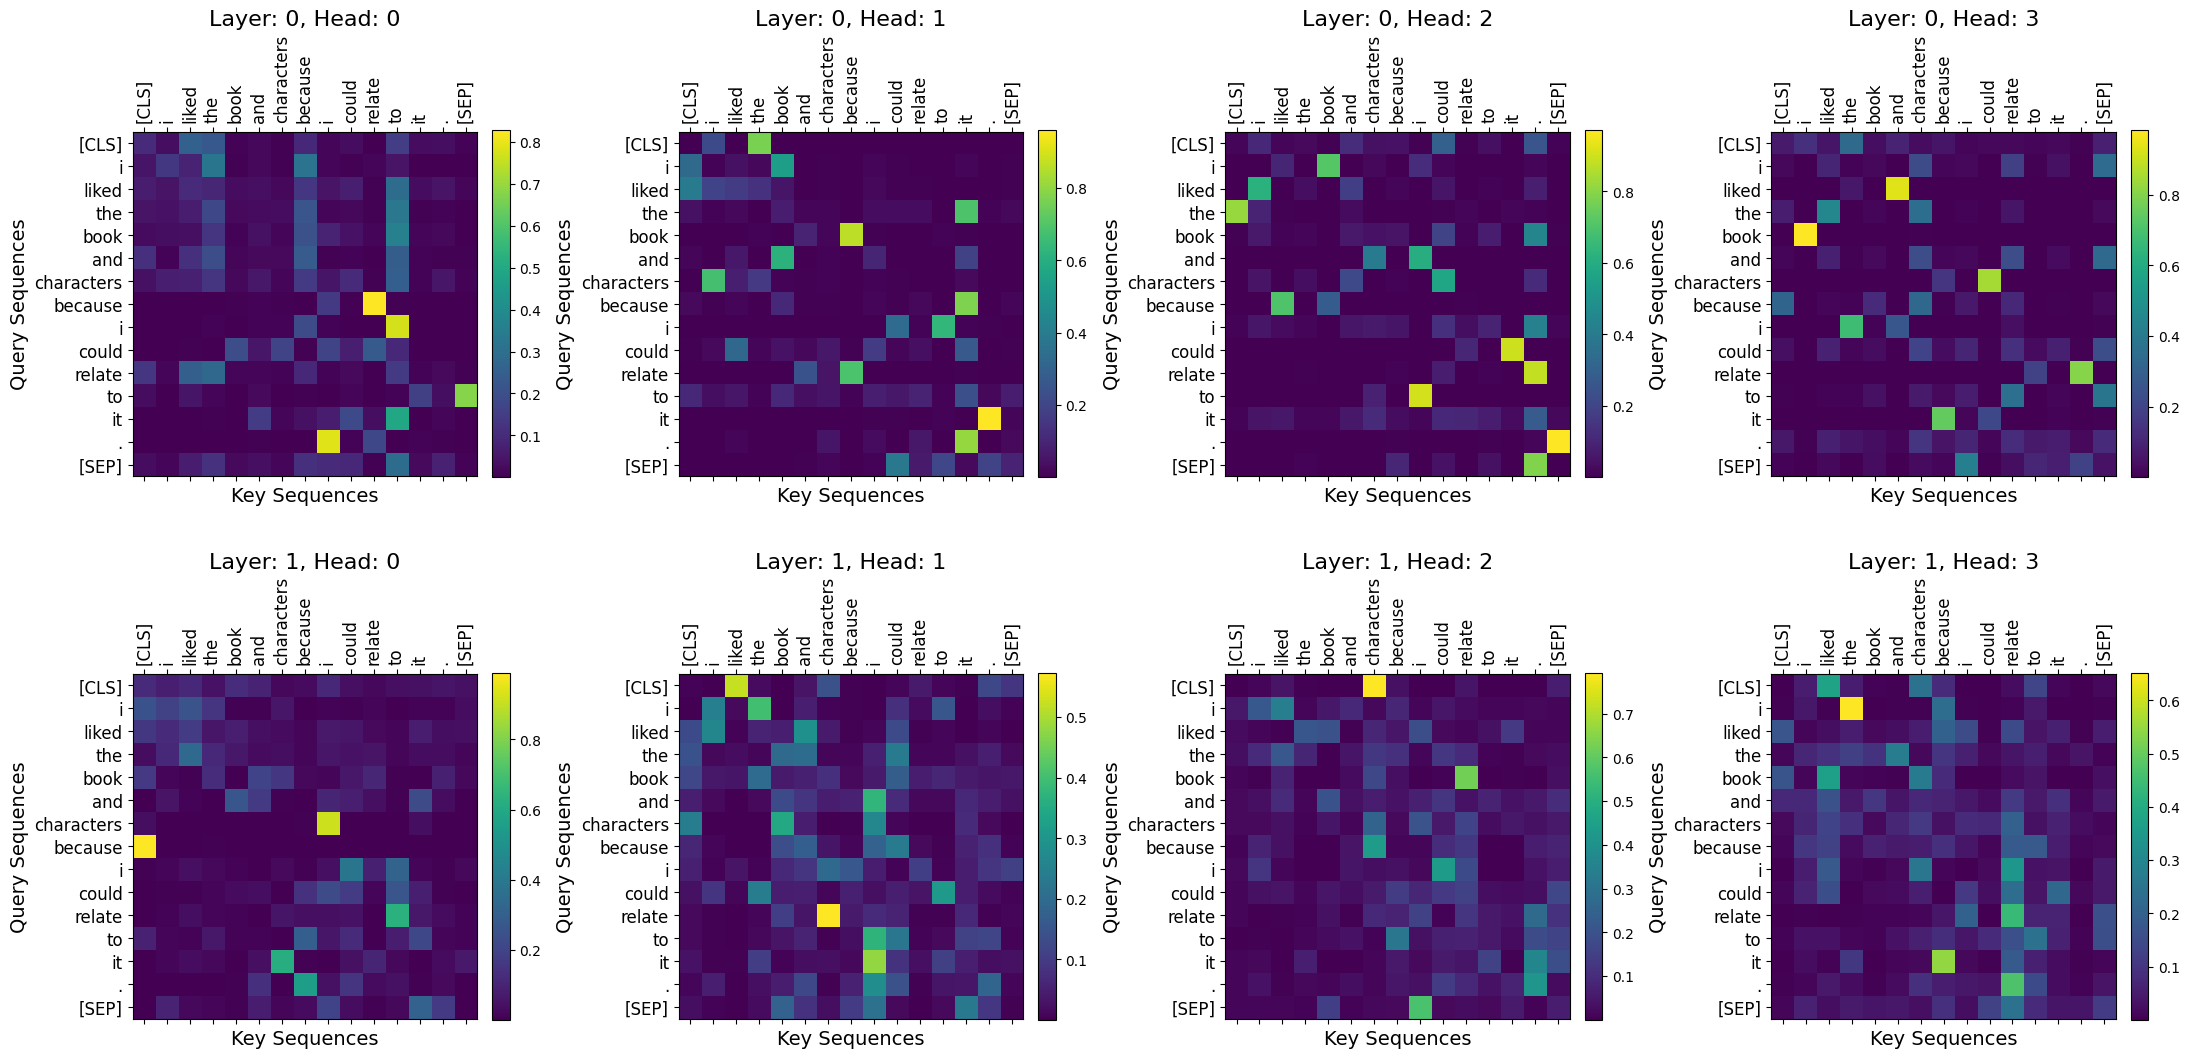

In [268]:
################################################################
# The visualization code below is provided for you. You can use it to visualize the attention weights of the BERT model.
# It takes the list of layer/head indices so that you can compare the attention weights across difference layers/heads

def attention_visualizer(sentence, model, tokenizer, layers=[-1], heads=[-1]):
    model.eval()
    with torch.no_grad():
        # Encode the sentence
        tokenized_input = tokenizer.encode(sentence)
        ids = tokenized_input.ids
        
        # Forward pass to get attention weights
        _, attns = model(torch.tensor([ids]).to(device))
        #attns = attns.transpose(1,0)
        print(attns.shape)
        
        # Determine the number of layers and heads to compare
        num_layers = len(layers)
        num_heads = len(heads)
        
        # Set up the figure for subplots
        fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*5.5, num_layers*5.5))
        
        # Handle the case for single subplot to maintain consistency
        if num_layers == 1 and num_heads == 1:
            axs = np.array([[axs]])
        
        # Convert axs to an array for easy indexing if it's not already
        if not isinstance(axs, np.ndarray):
            axs = np.array(axs)
        
        # Ensure axs is 2D
        if axs.ndim == 1:
            axs = np.expand_dims(axs, axis=0 if num_layers == 1 else 1)
        
        for i, layer in enumerate(layers):
            for j, head in enumerate(heads):
                # attn has shape [L, B, H, T_q, T_k]
                attn = attns[layer][0, head, :, :]
                
                # Extract the attention weights for visualization
                attn_weights = attn.squeeze(0).cpu().numpy()
                
                # Get the tokens for labels
                tokens = tokenized_input.tokens
                
                # Plot the attention heatmap
                cax = axs[i, j].matshow(attn_weights, cmap='viridis')
                fig.colorbar(cax, ax=axs[i, j], fraction=0.046, pad=0.04)
                
                # Set the tick labels
                axs[i, j].set_xticks(np.arange(len(tokens)))
                axs[i, j].set_yticks(np.arange(len(tokens)))
                axs[i, j].set_xticklabels(tokens, rotation=90, fontsize=12)
                axs[i, j].set_yticklabels(tokens, fontsize=12)
                axs[i, j].set_xlabel('Key Sequences', fontsize=14)
                axs[i, j].set_ylabel('Query Sequences', fontsize=14)
                axs[i, j].set_title(f'Layer: {layer}, Head: {head}', fontsize=16)
        
        plt.tight_layout()
        plt.show()

# Example usage
sentence = "I liked the book and characters because I could relate to it."
# Assuming 'bert' and 'tokenizer' are defined and initialized
# You should replace 'layers' and 'heads' with the specific indices you want to visualize
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])


torch.Size([2, 1, 4, 16, 16])


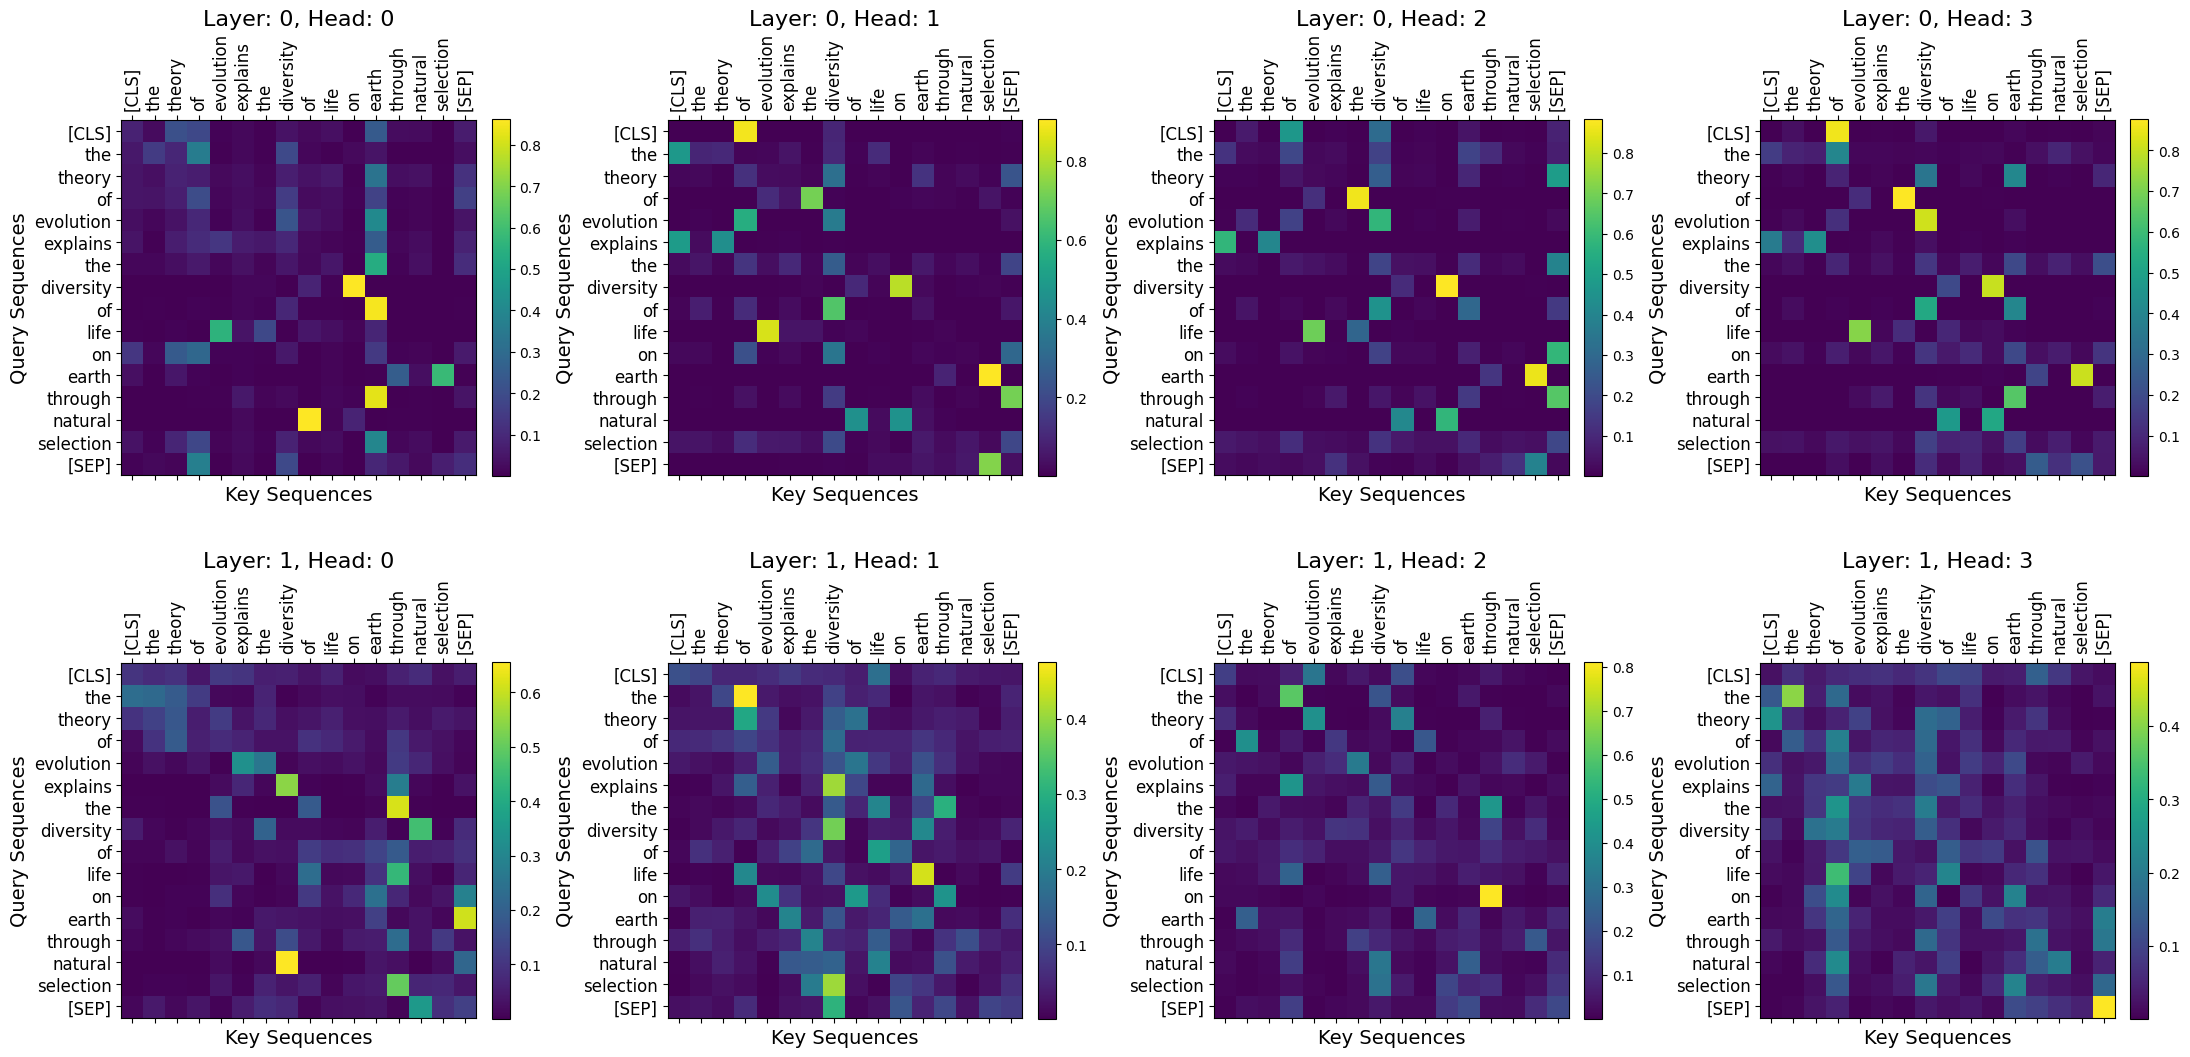

In [269]:
sentence = "The Theory of Evolution explains the diversity of life on Earth through natural selection"
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])

torch.Size([2, 1, 4, 17, 17])


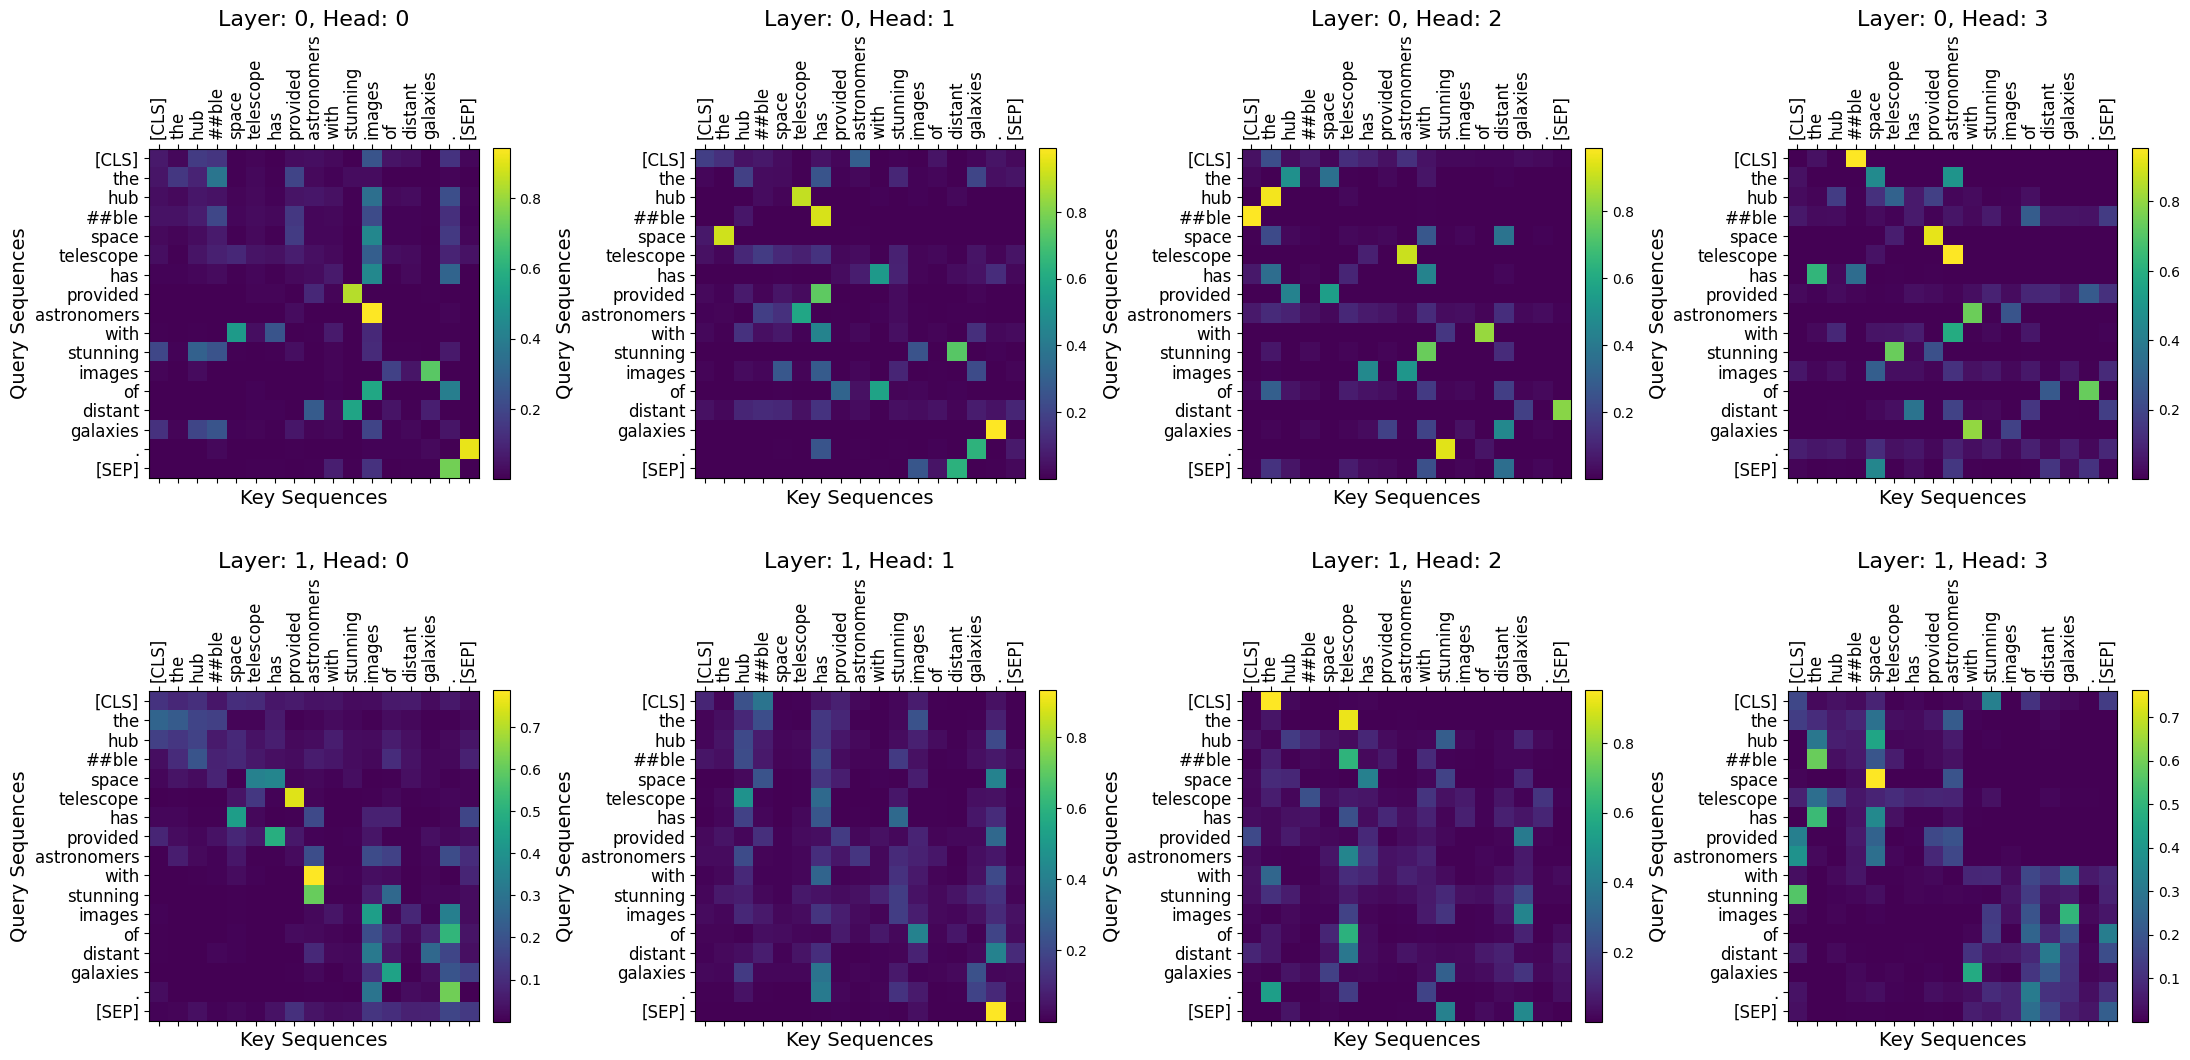

In [270]:
sentence = "The Hubble Space Telescope has provided astronomers with stunning images of distant galaxies."
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])

torch.Size([2, 1, 4, 12, 12])


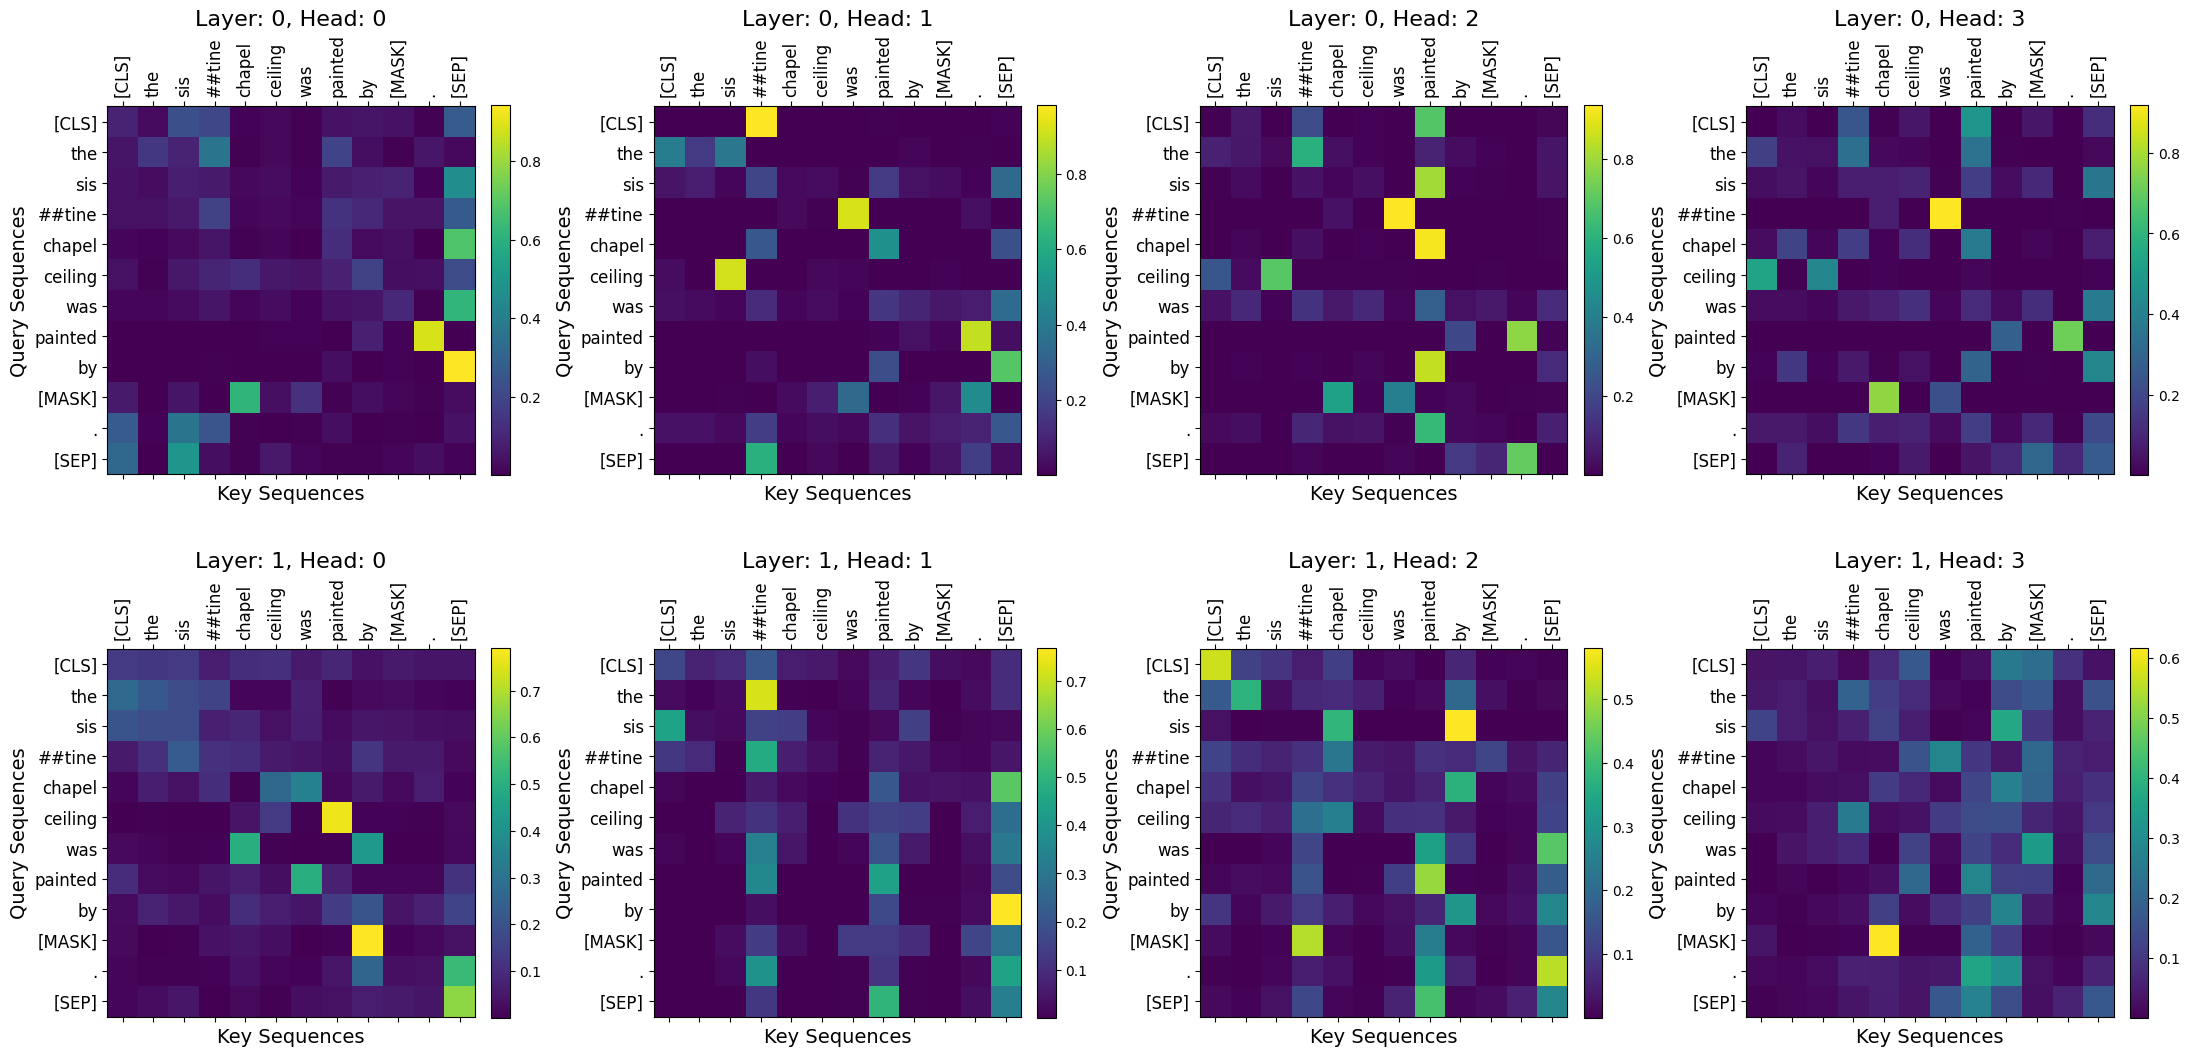

In [271]:
sentence = "The Sistine Chapel ceiling was painted by [MASK]."
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])

torch.Size([2, 1, 4, 22, 22])


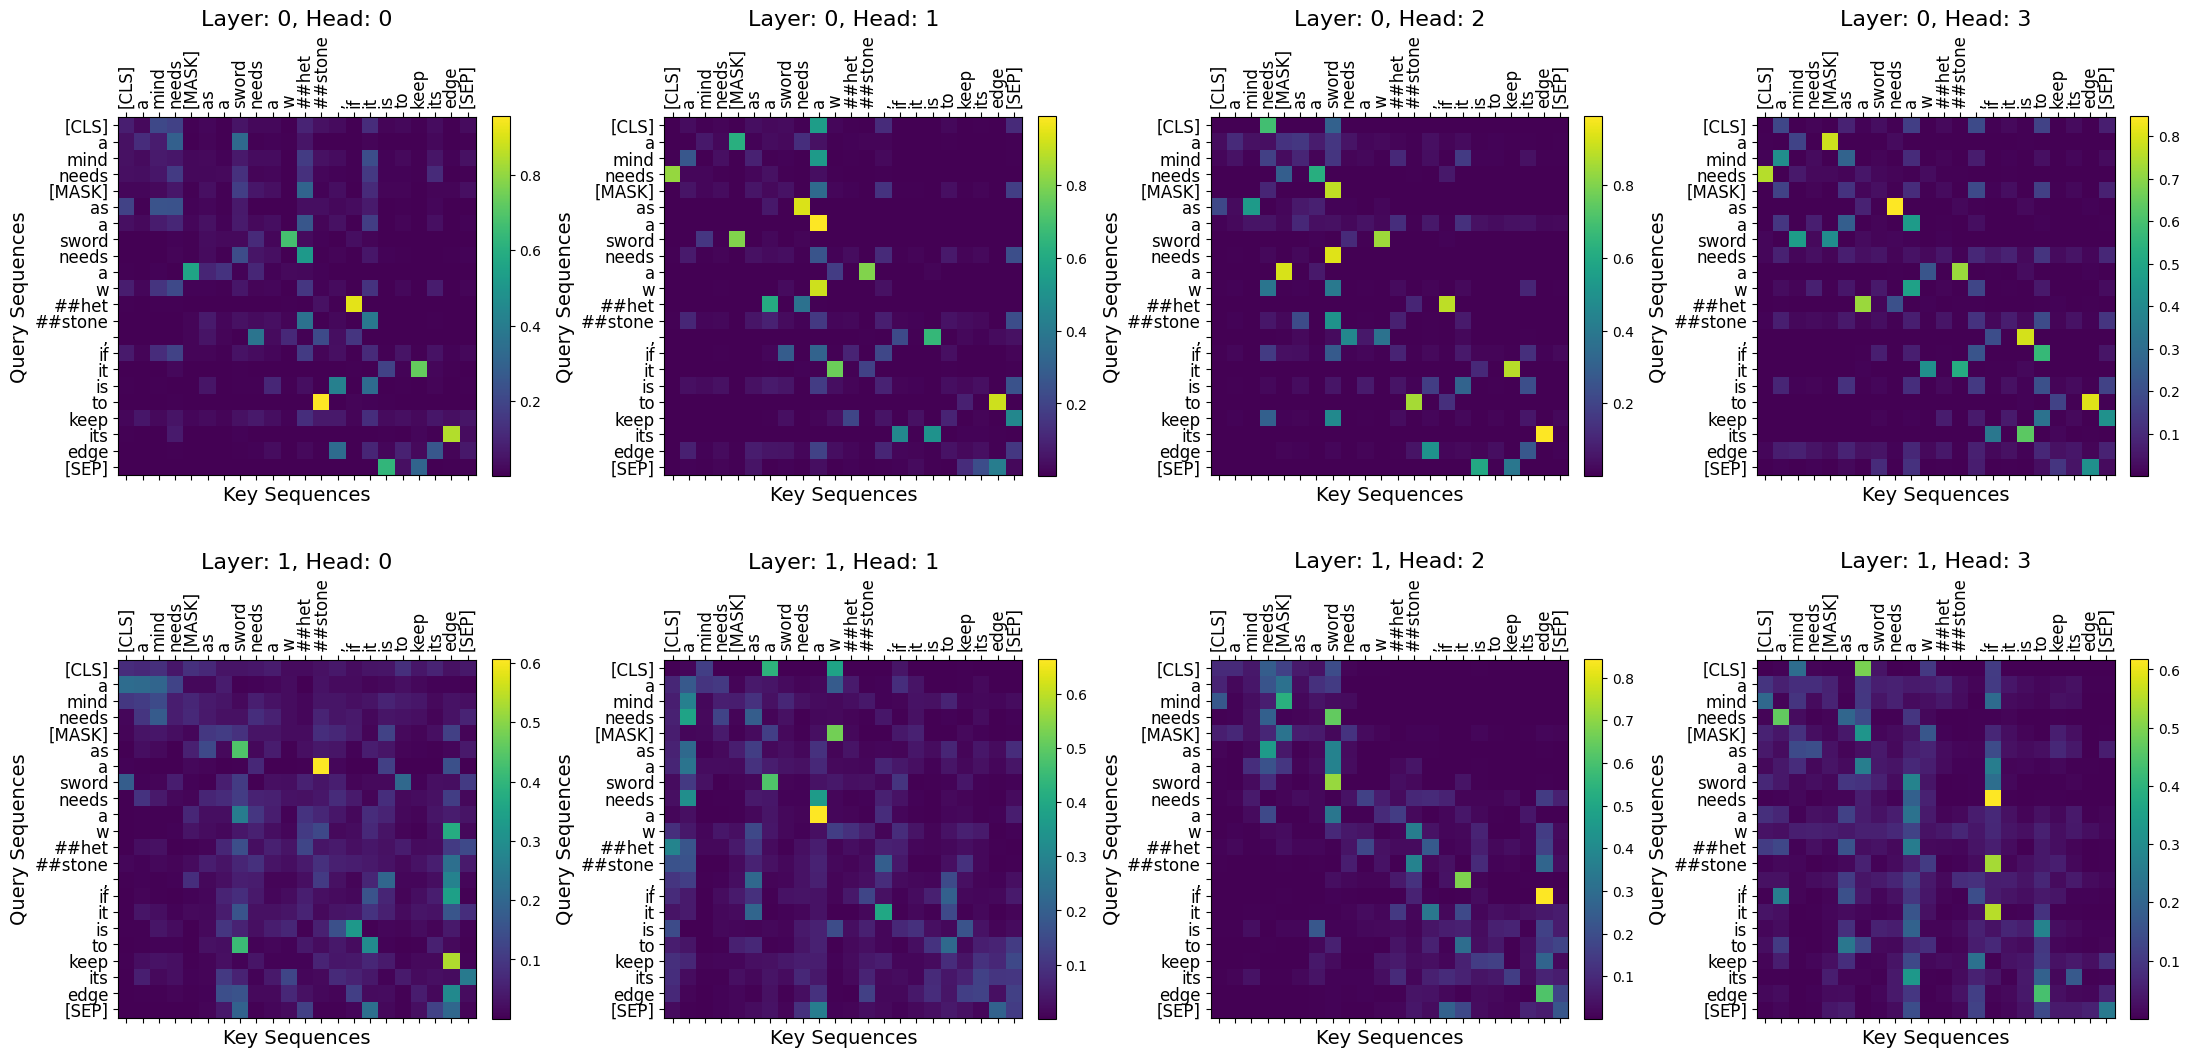

In [272]:
sentence = "A mind needs [MASK] as a sword needs a whetstone, if it is to keep its edge"
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])

torch.Size([2, 1, 4, 14, 14])


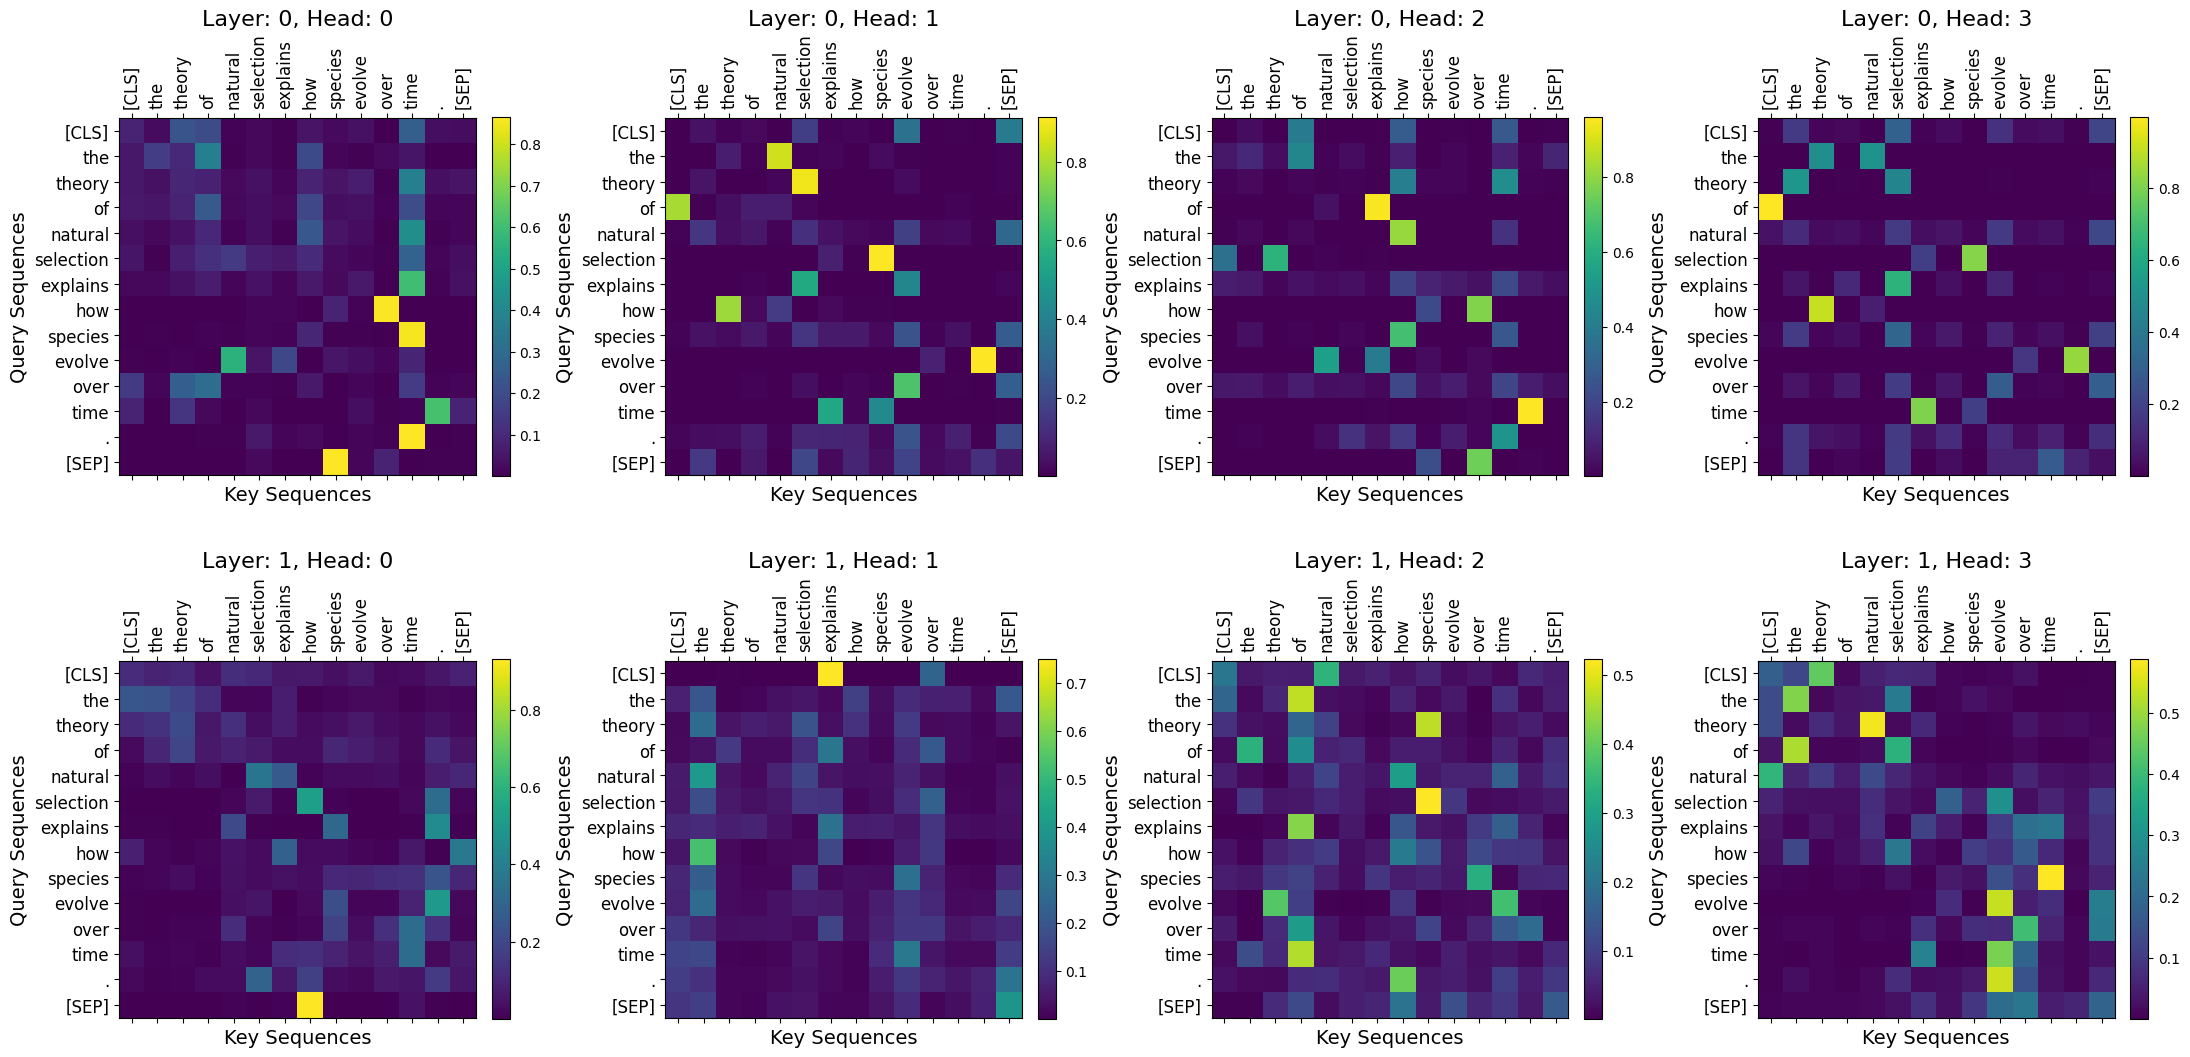

In [273]:
sentence = "The theory of natural selection explains how species evolve over time."
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1, 2, 3])